In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import explained_variance_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import sys
import tqdm as tqdm

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import cleaning_processing, preprocessing_Origins
import config_origins_chapter0 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
path_extracted_data = config.path_extracted_data
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#initialise parameters
obs_per_ind = 2 #sample size = obs_per_ind * ind (which vary from 10 to 100)
cov = 0.3
var = 1
min_EV = 0.9
pval_sign = 0.05
total_run = 10000

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
li_df = []
for num_samples_ in tqdm.tqdm(range(40,160,20)):
    num_samples = num_samples_*obs_per_ind
    print(num_samples)
    nbr_missing = 0
    for TR in tqdm.tqdm(range(0,total_run+300)):

        ############################### Simulate data ###############################
        #mean
        mu = np.array([0, 0])
        #covariance matrix
        r = np.array([[var, cov], 
                      [cov,  var]])
        #generate the random samples and plot it
        y = np.random.multivariate_normal(mu, r, size=num_samples)
        df = pd.DataFrame(y)
        #lets say one random var is tracking data and the other one is health indicator
        df['HA'] = df[1].copy()
        df['T_noise0'] = df[0].copy()

        ##################### add small noise until achieving 99% EV #####################
        #add noise
        EV_init = 1
        while EV_init != 0.99:
            cov_noise_99 = random.choices(range(4,10,1), k=1)[0]/100
            noise = np.random.normal(0,cov_noise_99,num_samples) #at each run it produces a different noise
            df['T_almost_99EV'] = df['T_noise0'] + noise
            #if EV == 0.99, we will keep it as initial data to evaluate the initial effect size and compare it with a 
            #data that have 0.91 EV (as in our finding)        
            EV_init = round(explained_variance_score(df['T_noise0'].tolist(), df['T_almost_99EV'].tolist()), 2)
     
        #################### Add random noise and match it to EV ####################
        li_coeff = []
        li_pval = []
        li_EV = []
        EV_actual = 1
        #while we still want to add noise (i.e. if the last EV is still higher than 0.9
        #k1: maximise to avoid beeing blocked somewhere, for this reason we augmented from 10000 to 10300
        k1 = 0
        while (EV_actual!=0.91)&(k1<1000):
            #add noise
            cov_noise = random.choices(range(10,30,1), k=1)[0]/100
            noise = np.random.normal(0,cov_noise,num_samples) #each run produces a different noise
            df['T_noiseX'] = df['T_noise0'] + noise
            #effect size in terms of pearson correlation between HA and trakcing with noise
            coeff,pval = stats.pearsonr(df['HA'].tolist(), df['T_noiseX'].tolist())
            #quantify in terms of EV the noise (explained_variance_score(y_true, y_pred))
            EV_actual = round(explained_variance_score(df['T_noise0'].tolist(), df['T_noiseX'].tolist()),2)
            k1 = k1+1                
        li_coeff.append(coeff)
        li_pval.append(pval)
        li_EV.append(EV_actual)
        init_effectsize_corr_pval = stats.pearsonr(df['HA'].tolist(), df['T_almost_99EV'].tolist())

        #enter results in a dataframe
        df_res = pd.DataFrame({'correlation coefficient':li_coeff, 'pvalue':li_pval, 'EV':li_EV})
        df_res['significant'] = df_res['pvalue'].map(lambda x: x<=pval_sign)
        #if initial effect size is significant (otherwise non sense to check)
        init_effectsize_pval = init_effectsize_corr_pval[1]
        init_effectsize = init_effectsize_corr_pval[0]
        df_res['initial correlation coefficient'] = init_effectsize
        df_res['initial correlation pval'] = init_effectsize_pval
        df_res['TR'] = TR
        df_res['num_samples'] = num_samples
        li_df.append(df_res)
        
df_allresults = pd.concat(li_df)
df_allresults['initial significance'] = df_allresults['initial correlation pval'].map(lambda x: x<=pval_sign)
df_allresults['initial correlation coefficient class'] = df_allresults['initial correlation coefficient'].map(lambda x: round(x,2))
df_allresults.to_csv(os.path.join(path_extracted_data_cleaning, 'df_resultresults_measurementerror_effectsize.csv'))
print(df_allresults.shape)
display(df_allresults.head(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                               | 10/10300 [00:00<01:49, 93.68it/s]

80



  4%|██▉                                                                           | 380/10300 [00:13<04:35, 36.03it/s]


  7%|█████▏                                                                        | 682/10300 [00:27<05:40, 28.28it/s]


 10%|███████▌                                                                     | 1019/10300 [00:41<12:11, 12.69it/s]


 13%|██████████▏                                                                  | 1365/10300 [00:57<11:15, 13.23it/s]


 17%|█████████████                                                                | 1740/10300 [01:12<06:36, 21.56it/s]


 20%|███████████████▌                                                             | 2082/10300 [01:27<09:14, 14.81it/s]


 23%|██████████████████                                                           | 2410/10300 [01:41<13:38,  9.63it/s]


 27%|████████████████████▌                                                        | 2754/10300 [01:56<07:30, 16.74it/s]


 29%|██████████████████████▋                                                      | 3037/10300 [02:11<04:44, 25.57it/s]


 33%|█████████████████████████▎                                                   | 3390/10300 [02:23<03:27, 33.31it/s]


 36%|███████████████████████████▊                                                 | 3726/10300 [02:37<07:23, 14.83it/s]


 40%|██████████████████████████████▍                                              | 4070/10300 [02:52<03:48, 27.26it/s]


 43%|████████████████████████████████▉                                            | 4406/10300 [03:09<05:28, 17.95it/s]


 46%|███████████████████████████████████▋                                         | 4772/10300 [03:23<03:47, 24.32it/s]


 50%|██████████████████████████████████████▏                                      | 5112/10300 [03:36<04:09, 20.81it/s]


 53%|████████████████████████████████████████▌                                    | 5428/10300 [03:51<02:49, 28.81it/s]


 56%|██████████████████████████████████████████▊                                  | 5734/10300 [04:08<05:55, 12.84it/s]


 58%|█████████████████████████████████████████████                                | 6024/10300 [04:21<02:47, 25.50it/s]


 62%|███████████████████████████████████████████████▍                             | 6349/10300 [04:35<03:18, 19.89it/s]


 65%|█████████████████████████████████████████████████▉                           | 6678/10300 [04:51<02:04, 29.12it/s]


 68%|████████████████████████████████████████████████████                         | 6971/10300 [05:07<04:45, 11.64it/s]


 71%|██████████████████████████████████████████████████████▍                      | 7279/10300 [05:23<02:48, 17.89it/s]


 74%|████████████████████████████████████████████████████████▉                    | 7624/10300 [05:37<01:11, 37.53it/s]


 77%|███████████████████████████████████████████████████████████▌                 | 7960/10300 [05:51<02:00, 19.41it/s]


 80%|█████████████████████████████████████████████████████████████▉               | 8282/10300 [06:07<02:27, 13.73it/s]


 84%|████████████████████████████████████████████████████████████████▎            | 8602/10300 [06:20<01:00, 27.94it/s]


 87%|██████████████████████████████████████████████████████████████████▋          | 8928/10300 [06:36<01:38, 13.90it/s]


 90%|█████████████████████████████████████████████████████████████████████▏       | 9251/10300 [06:51<00:41, 25.33it/s]


 93%|███████████████████████████████████████████████████████████████████████▍     | 9560/10300 [07:08<01:47,  6.89it/s]


 96%|█████████████████████████████████████████████████████████████████████████▊   | 9866/10300 [07:24<00:23, 18.85it/s]


 99%|███████████████████████████████████████████████████████████████████████████▎| 10205/10300 [07:41<00:06, 14.74it/s]


  0%|                                                                                | 3/10300 [00:00<06:09, 27.85it/s]

120



  3%|██▌                                                                           | 332/10300 [00:15<12:32, 13.25it/s]


  6%|████▉                                                                         | 653/10300 [00:30<06:51, 23.44it/s]


  9%|███████▎                                                                      | 964/10300 [00:48<08:33, 18.20it/s]


 12%|█████████▍                                                                   | 1263/10300 [01:02<05:20, 28.23it/s]


 15%|███████████▌                                                                 | 1547/10300 [01:17<08:04, 18.06it/s]


 18%|█████████████▋                                                               | 1838/10300 [01:33<08:20, 16.91it/s]


 21%|████████████████▏                                                            | 2171/10300 [01:47<04:36, 29.36it/s]


 24%|██████████████████▌                                                          | 2491/10300 [02:02<04:07, 31.53it/s]


 28%|█████████████████████▎                                                       | 2858/10300 [02:19<07:35, 16.35it/s]


 31%|███████████████████████▋                                                     | 3175/10300 [02:33<03:54, 30.39it/s]


 34%|██████████████████████████▏                                                  | 3500/10300 [02:48<03:53, 29.14it/s]


 37%|████████████████████████████▍                                                | 3811/10300 [03:04<05:15, 20.58it/s]


 40%|██████████████████████████████▉                                              | 4142/10300 [03:17<05:12, 19.73it/s]


 43%|█████████████████████████████████▏                                           | 4441/10300 [03:32<03:18, 29.57it/s]


 46%|███████████████████████████████████▋                                         | 4772/10300 [03:48<03:59, 23.07it/s]


 50%|██████████████████████████████████████                                       | 5099/10300 [04:02<04:03, 21.38it/s]


 53%|████████████████████████████████████████▍                                    | 5416/10300 [04:17<04:53, 16.65it/s]


 56%|██████████████████████████████████████████▊                                  | 5733/10300 [04:34<05:33, 13.71it/s]


 59%|█████████████████████████████████████████████▏                               | 6038/10300 [04:52<06:19, 11.22it/s]


 62%|███████████████████████████████████████████████▋                             | 6379/10300 [05:07<02:27, 26.64it/s]


 65%|█████████████████████████████████████████████████▉                           | 6674/10300 [05:21<02:53, 20.87it/s]


 68%|████████████████████████████████████████████████████▎                        | 6992/10300 [05:36<02:08, 25.73it/s]


 71%|██████████████████████████████████████████████████████▉                      | 7354/10300 [05:50<01:23, 35.22it/s]


 74%|█████████████████████████████████████████████████████████▏                   | 7652/10300 [06:06<01:40, 26.23it/s]


 77%|███████████████████████████████████████████████████████████▌                 | 7970/10300 [06:22<01:26, 27.04it/s]


 80%|█████████████████████████████████████████████████████████████▉               | 8282/10300 [06:38<01:14, 27.04it/s]


 83%|████████████████████████████████████████████████████████████████▏            | 8582/10300 [06:53<01:20, 21.47it/s]


 86%|██████████████████████████████████████████████████████████████████▌          | 8904/10300 [07:09<01:32, 15.09it/s]


 90%|████████████████████████████████████████████████████████████████████▉        | 9222/10300 [07:22<02:05,  8.60it/s]


 92%|██████████████████████████████████████████████████████████████████████▉      | 9493/10300 [07:36<00:37, 21.59it/s]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 9820/10300 [07:51<00:24, 19.32it/s]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 10104/10300 [08:07<00:31,  6.31it/s]


  0%|                                                                                        | 0/10300 [00:00<?, ?it/s]


160


  3%|██                                                                            | 273/10300 [00:15<07:40, 21.78it/s]


  5%|████▏                                                                         | 561/10300 [00:33<16:48,  9.66it/s]


  8%|██████▏                                                                       | 814/10300 [00:49<07:03, 22.39it/s]


 11%|████████▍                                                                    | 1129/10300 [01:05<16:56,  9.02it/s]


 14%|██████████▋                                                                  | 1422/10300 [01:20<08:06, 18.26it/s]


 17%|████████████▉                                                                | 1725/10300 [01:35<05:04, 28.14it/s]


 20%|███████████████▎                                                             | 2045/10300 [01:52<12:09, 11.32it/s]


 23%|█████████████████▌                                                           | 2355/10300 [02:07<06:42, 19.74it/s]


 26%|███████████████████▉                                                         | 2669/10300 [02:22<05:28, 23.20it/s]


 29%|██████████████████████▏                                                      | 2967/10300 [02:38<04:24, 27.78it/s]


 32%|████████████████████████▌                                                    | 3278/10300 [02:54<06:35, 17.75it/s]


 35%|██████████████████████████▊                                                  | 3588/10300 [03:08<05:54, 18.94it/s]


 38%|█████████████████████████████▏                                               | 3908/10300 [03:22<04:31, 23.51it/s]


 41%|███████████████████████████████▌                                             | 4227/10300 [03:40<03:37, 27.89it/s]


 44%|█████████████████████████████████▉                                           | 4538/10300 [03:56<04:57, 19.39it/s]


 47%|████████████████████████████████████▏                                        | 4836/10300 [04:11<07:59, 11.39it/s]


 50%|██████████████████████████████████████▌                                      | 5151/10300 [04:25<03:19, 25.86it/s]


 53%|████████████████████████████████████████▉                                    | 5479/10300 [04:39<02:40, 30.01it/s]


 56%|███████████████████████████████████████████▎                                 | 5795/10300 [04:53<03:01, 24.87it/s]


 59%|█████████████████████████████████████████████▍                               | 6083/10300 [05:10<03:34, 19.66it/s]


 62%|███████████████████████████████████████████████▌                             | 6362/10300 [05:27<03:52, 16.92it/s]


 65%|██████████████████████████████████████████████████                           | 6690/10300 [05:42<02:58, 20.19it/s]


 68%|████████████████████████████████████████████████████▎                        | 6998/10300 [05:58<03:51, 14.26it/s]


 71%|██████████████████████████████████████████████████████▌                      | 7304/10300 [06:13<03:12, 15.54it/s]


 74%|████████████████████████████████████████████████████████▊                    | 7592/10300 [06:26<02:06, 21.48it/s]


 77%|██████████████████████████████████████████████████████████▉                  | 7889/10300 [06:41<02:40, 14.98it/s]


 79%|█████████████████████████████████████████████████████████████▏               | 8178/10300 [06:58<02:06, 16.76it/s]


 82%|███████████████████████████████████████████████████████████████▎             | 8476/10300 [07:14<01:30, 20.26it/s]


 85%|█████████████████████████████████████████████████████████████████▌           | 8772/10300 [07:30<01:01, 25.02it/s]


 88%|███████████████████████████████████████████████████████████████████▋         | 9057/10300 [07:45<00:53, 23.20it/s]


 91%|██████████████████████████████████████████████████████████████████████▏      | 9396/10300 [07:59<00:43, 20.59it/s]


 94%|████████████████████████████████████████████████████████████████████████▋    | 9725/10300 [08:14<00:30, 19.14it/s]


 98%|██████████████████████████████████████████████████████████████████████████▏ | 10059/10300 [08:28<00:10, 23.09it/s]


  0%|                                                                                | 4/10300 [00:00<06:35, 26.04it/s]

200



  3%|██▎                                                                           | 304/10300 [00:15<27:39,  6.02it/s]


  6%|████▌                                                                         | 609/10300 [00:31<09:39, 16.72it/s]


  9%|██████▉                                                                       | 916/10300 [00:48<09:33, 16.36it/s]


 12%|████████▉                                                                    | 1199/10300 [01:06<11:36, 13.07it/s]


 15%|███████████▎                                                                 | 1509/10300 [01:21<05:19, 27.49it/s]


 17%|█████████████▎                                                               | 1787/10300 [01:38<10:53, 13.02it/s]


 20%|███████████████▋                                                             | 2101/10300 [01:54<07:44, 17.66it/s]


 24%|██████████████████▏                                                          | 2433/10300 [02:10<05:17, 24.77it/s]


 27%|████████████████████▌                                                        | 2745/10300 [02:27<05:15, 23.91it/s]


 30%|███████████████████████▏                                                     | 3094/10300 [02:44<06:24, 18.75it/s]


 33%|█████████████████████████▌                                                   | 3425/10300 [03:00<11:02, 10.38it/s]


 36%|███████████████████████████▉                                                 | 3732/10300 [03:15<04:39, 23.52it/s]


 39%|██████████████████████████████▏                                              | 4032/10300 [03:33<04:48, 21.69it/s]


 42%|████████████████████████████████▎                                            | 4328/10300 [03:49<05:43, 17.39it/s]


 45%|██████████████████████████████████▌                                          | 4627/10300 [04:05<09:59,  9.46it/s]


 48%|████████████████████████████████████▉                                        | 4942/10300 [04:20<04:43, 18.92it/s]


 51%|███████████████████████████████████████                                      | 5224/10300 [04:37<04:35, 18.45it/s]


 54%|█████████████████████████████████████████▎                                   | 5523/10300 [04:54<08:16,  9.62it/s]


 56%|███████████████████████████████████████████▎                                 | 5789/10300 [05:10<04:38, 16.17it/s]


 59%|█████████████████████████████████████████████▎                               | 6069/10300 [05:24<06:43, 10.49it/s]


 62%|███████████████████████████████████████████████▌                             | 6358/10300 [05:41<03:24, 19.32it/s]


 65%|█████████████████████████████████████████████████▊                           | 6666/10300 [05:57<05:09, 11.75it/s]


 67%|███████████████████████████████████████████████████▉                         | 6949/10300 [06:11<02:57, 18.93it/s]


 70%|██████████████████████████████████████████████████████▎                      | 7257/10300 [06:26<01:31, 33.18it/s]


 73%|████████████████████████████████████████████████████████▍                    | 7554/10300 [06:40<01:44, 26.34it/s]


 76%|██████████████████████████████████████████████████████████▊                  | 7866/10300 [06:55<02:25, 16.69it/s]


 79%|████████████████████████████████████████████████████████████▉                | 8144/10300 [07:13<05:53,  6.10it/s]


 82%|███████████████████████████████████████████████████████████████              | 8442/10300 [07:27<00:54, 33.93it/s]


 85%|█████████████████████████████████████████████████████████████████▍           | 8757/10300 [07:42<03:48,  6.74it/s]


 88%|███████████████████████████████████████████████████████████████████▋         | 9049/10300 [07:59<00:59, 20.89it/s]


 90%|█████████████████████████████████████████████████████████████████████▌       | 9309/10300 [08:14<00:58, 16.97it/s]


 93%|███████████████████████████████████████████████████████████████████████▉     | 9620/10300 [08:28<00:28, 23.60it/s]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 9898/10300 [08:46<00:26, 15.41it/s]


 99%|███████████████████████████████████████████████████████████████████████████▎| 10207/10300 [09:03<00:08, 11.17it/s]


  0%|                                                                                | 5/10300 [00:00<04:24, 38.87it/s]

240



  3%|██                                                                            | 270/10300 [00:18<17:48,  9.38it/s]


  5%|████▏                                                                         | 548/10300 [00:35<10:16, 15.83it/s]


  8%|██████▎                                                                       | 841/10300 [00:50<10:18, 15.28it/s]


 11%|████████▍                                                                    | 1125/10300 [01:08<11:38, 13.13it/s]


 14%|██████████▌                                                                  | 1415/10300 [01:25<10:43, 13.82it/s]


 17%|████████████▊                                                                | 1712/10300 [01:40<08:23, 17.06it/s]


 19%|██████████████▉                                                              | 2005/10300 [01:56<10:18, 13.41it/s]


 22%|█████████████████▏                                                           | 2297/10300 [02:12<07:17, 18.30it/s]


 25%|███████████████████▎                                                         | 2579/10300 [02:28<08:58, 14.34it/s]


 28%|█████████████████████▌                                                       | 2884/10300 [02:46<05:41, 21.74it/s]


 31%|███████████████████████▋                                                     | 3173/10300 [03:04<08:15, 14.37it/s]


 34%|█████████████████████████▊                                                   | 3455/10300 [03:20<17:24,  6.55it/s]


 36%|███████████████████████████▉                                                 | 3736/10300 [03:36<12:04,  9.06it/s]


 39%|█████████████████████████████▉                                               | 3997/10300 [03:53<05:45, 18.24it/s]


 42%|████████████████████████████████                                             | 4295/10300 [04:06<05:48, 17.21it/s]


 44%|██████████████████████████████████▏                                          | 4573/10300 [04:23<03:34, 26.73it/s]


 47%|████████████████████████████████████▍                                        | 4872/10300 [04:39<02:48, 32.26it/s]


 50%|██████████████████████████████████████▊                                      | 5190/10300 [04:54<03:05, 27.59it/s]


 53%|████████████████████████████████████████▉                                    | 5480/10300 [05:10<06:52, 11.69it/s]


 56%|███████████████████████████████████████████▏                                 | 5783/10300 [05:25<02:31, 29.78it/s]


 59%|█████████████████████████████████████████████▍                               | 6080/10300 [05:43<02:47, 25.25it/s]


 62%|███████████████████████████████████████████████▉                             | 6409/10300 [06:01<03:53, 16.67it/s]


 65%|██████████████████████████████████████████████████                           | 6700/10300 [06:15<03:02, 19.77it/s]


 68%|████████████████████████████████████████████████████▎                        | 6996/10300 [06:33<03:05, 17.82it/s]


 71%|██████████████████████████████████████████████████████▍                      | 7279/10300 [06:50<04:23, 11.45it/s]


 74%|████████████████████████████████████████████████████████▋                    | 7582/10300 [07:10<04:16, 10.58it/s]


 77%|███████████████████████████████████████████████████████████▏                 | 7917/10300 [07:24<02:07, 18.69it/s]


 80%|█████████████████████████████████████████████████████████████▌               | 8238/10300 [07:41<01:09, 29.66it/s]


 83%|███████████████████████████████████████████████████████████████▉             | 8553/10300 [07:58<02:09, 13.47it/s]


 86%|██████████████████████████████████████████████████████████████████▏          | 8857/10300 [08:17<01:50, 13.10it/s]


 89%|████████████████████████████████████████████████████████████████████▍        | 9159/10300 [08:34<00:49, 23.04it/s]


 92%|██████████████████████████████████████████████████████████████████████▋      | 9454/10300 [08:48<00:33, 25.54it/s]


 94%|████████████████████████████████████████████████████████████████████████▋    | 9726/10300 [09:05<00:17, 33.03it/s]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9993/10300 [09:21<00:17, 18.03it/s]


100%|███████████████████████████████████████████████████████████████████████████▉| 10290/10300 [09:38<00:00, 11.53it/s]


  0%|                                                                                        | 0/10300 [00:00<?, ?it/s]

280



  3%|██▏                                                                           | 282/10300 [00:16<05:20, 31.28it/s]


  6%|████▍                                                                         | 584/10300 [00:32<08:34, 18.87it/s]


  8%|██████▌                                                                       | 872/10300 [00:49<07:54, 19.89it/s]


 11%|████████▍                                                                    | 1130/10300 [01:07<11:37, 13.14it/s]


 14%|██████████▌                                                                  | 1416/10300 [01:23<14:39, 10.10it/s]


 16%|████████████▋                                                                | 1696/10300 [01:38<20:14,  7.09it/s]


 19%|██████████████▋                                                              | 1973/10300 [01:53<09:37, 14.42it/s]


 22%|████████████████▉                                                            | 2260/10300 [02:08<06:43, 19.94it/s]


 25%|██████████████████▉                                                          | 2537/10300 [02:24<08:20, 15.52it/s]


 27%|████████████████████▊                                                        | 2786/10300 [02:43<10:51, 11.54it/s]


 30%|██████████████████████▊                                                      | 3046/10300 [03:01<07:18, 16.55it/s]


 32%|████████████████████████▊                                                    | 3314/10300 [03:16<05:25, 21.49it/s]


 35%|███████████████████████████                                                  | 3628/10300 [03:31<04:18, 25.81it/s]


 38%|█████████████████████████████▎                                               | 3913/10300 [03:46<08:42, 12.24it/s]


 41%|███████████████████████████████▌                                             | 4224/10300 [04:00<02:56, 34.47it/s]


 44%|█████████████████████████████████▋                                           | 4505/10300 [04:20<05:48, 16.64it/s]


 46%|███████████████████████████████████▊                                         | 4785/10300 [04:36<03:58, 23.14it/s]


 49%|██████████████████████████████████████                                       | 5094/10300 [04:55<06:17, 13.79it/s]


 52%|████████████████████████████████████████▎                                    | 5385/10300 [05:12<07:19, 11.18it/s]


 55%|██████████████████████████████████████████▌                                  | 5691/10300 [05:27<04:36, 16.69it/s]


 58%|████████████████████████████████████████████▌                                | 5955/10300 [05:46<06:42, 10.79it/s]


 60%|██████████████████████████████████████████████▍                              | 6218/10300 [06:05<05:32, 12.28it/s]


 63%|████████████████████████████████████████████████▊                            | 6529/10300 [06:22<02:03, 30.54it/s]


 66%|██████████████████████████████████████████████████▉                          | 6818/10300 [06:40<06:24,  9.05it/s]


 69%|█████████████████████████████████████████████████████                        | 7106/10300 [06:55<04:49, 11.04it/s]


 72%|███████████████████████████████████████████████████████▍                     | 7415/10300 [07:10<06:09,  7.81it/s]


 74%|█████████████████████████████████████████████████████████▎                   | 7669/10300 [07:25<01:47, 24.57it/s]


 77%|███████████████████████████████████████████████████████████▌                 | 7960/10300 [07:43<02:26, 15.95it/s]


 80%|█████████████████████████████████████████████████████████████▋               | 8253/10300 [07:58<01:27, 23.52it/s]


 83%|███████████████████████████████████████████████████████████████▌             | 8505/10300 [08:15<03:50,  7.80it/s]


 85%|█████████████████████████████████████████████████████████████████▊           | 8797/10300 [08:32<01:28, 16.93it/s]


 88%|███████████████████████████████████████████████████████████████████▉         | 9096/10300 [08:45<00:48, 25.08it/s]


 91%|██████████████████████████████████████████████████████████████████████▏      | 9384/10300 [09:02<00:56, 16.26it/s]


 94%|████████████████████████████████████████████████████████████████████████▌    | 9701/10300 [09:19<00:29, 20.54it/s]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9984/10300 [09:34<00:11, 26.78it/s]


100%|███████████████████████████████████████████████████████████████████████████▋| 10254/10300 [09:49<00:02, 15.51it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [53:25<00:00, 534.30s/it]


(61800, 10)


,correlation coefficient,pvalue,EV,significant,initial correlation coefficient,initial correlation pval,TR,num_samples,initial significance,initial correlation coefficient class
0,0.288455,0.009464,0.91,True,0.315858,0.004316,0,80,True,0.32
0,-0.079504,0.483286,0.91,False,-0.065980,0.560912,1,80,False,-0.07
0,0.262356,0.018723,0.91,True,0.296091,0.007660,2,80,True,0.30
0,0.374462,0.000622,0.91,True,0.374900,0.000612,3,80,True,0.37
0,0.273458,0.014113,0.91,True,0.291623,0.008675,4,80,True,0.29


In [8]:
df_allresults.to_csv(os.path.join(path_extracted_data_cleaning, 'df_resultresults_measurementerror_effectsize.csv'))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#all points have at least X obs and all significant to avoid

In [9]:
#select for our special case of 99% to 91%
df_ourres = df_allresults[df_allresults['initial correlation coefficient']<=0.4]
print(df_ourres.shape, df_allresults.shape)
df_ourres.head()

(57203, 10) (61800, 10)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,correlation coefficient,pvalue,EV,significant,initial correlation coefficient,initial correlation pval,TR,num_samples,initial significance,initial correlation coefficient class
0,0.288455,0.009464,0.91,True,0.315858,0.004316,0,80,True,0.32
0,-0.079504,0.483286,0.91,False,-0.065980,0.560912,1,80,False,-0.07
0,0.262356,0.018723,0.91,True,0.296091,0.007660,2,80,True,0.30
0,0.374462,0.000622,0.91,True,0.374900,0.000612,3,80,True,0.37
0,0.273458,0.014113,0.91,True,0.291623,0.008675,4,80,True,0.29


In [12]:
#by construction, we have a random initial effect size (corr. coeff.) per TR and one obs per TR 
df_naturalsign = df_ourres.groupby(['initial correlation coefficient class','num_samples'])['initial significance'].agg(lambda x: list(x)).reset_index()
df_naturalsign['% initial non-significance'] = df_naturalsign['initial significance'].map(lambda x: (1-(sum(x)/len(x)))*100)
df_naturalsign.filter(['% initial non-significance','initial correlation coefficient class','num_samples'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,% initial non-significance,initial correlation coefficient class,num_samples
0,100.0,-0.12,80
1,100.0,-0.10,80
2,100.0,-0.09,80
3,100.0,-0.08,80
4,100.0,-0.07,80
...,...,...,...
238,0.0,0.40,120
239,0.0,0.40,160
240,0.0,0.40,200
241,0.0,0.40,240


(243, 5)
(243, 6)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,% initial non-significance,initial correlation coefficient class,num_samples,significant,% that lost significance,nbr_obs
0,100.0,-0.12,80,[False],100.0,1
1,100.0,-0.10,80,"[False, False]",100.0,2
2,100.0,-0.09,80,"[False, False, False]",100.0,3


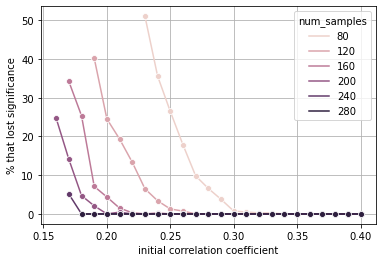

In [23]:
#visualise the lost in significance
df_sign = df_ourres.groupby(['initial correlation coefficient class','num_samples'])['significant'].agg(lambda x: list(x)).reset_index()
df_sign['% that lost significance'] = df_sign['significant'].map(lambda x: (1-(sum(x)/len(x)))*100)
df_sign['nbr_obs'] = df_sign['significant'].map(lambda x: len(x))
print(df_sign.shape)
df_sign = pd.merge(df_naturalsign.filter(['% initial non-significance','initial correlation coefficient class','num_samples']), 
                  df_sign, on=['num_samples','initial correlation coefficient class'], how='left')
print(df_sign.shape)
display(df_sign.head(3))
df_canuse = df_sign[(df_sign['% initial non-significance']==0)&(df_sign['nbr_obs']>50)]
sns.lineplot(x='initial correlation coefficient class', y='% that lost significance', 
            data=df_canuse, hue='num_samples', marker="o");
plt.xlabel('initial correlation coefficient')
plt.grid(True)
plt.savefig(os.path.join(path_extracted_data_cleaning,'simulatedEffectofMeasurementErrors.png'), dpi=300, bbox_inches='tight')

In [19]:
df_canuse['% that lost significance'] = df_canuse['% that lost significance'].map(lambda x: round(x,2))
df_canuse.sort_values(['initial correlation coefficient class'], 
                      ascending=True).groupby(['num_samples'])[['% initial non-significance','% that lost significance','nbr_obs',
                                                                'initial correlation coefficient class']].agg(lambda x: list(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-19-d395a5bafdc1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canuse['% that lost significance'] = df_canuse['% that lost significance'].map(lambda x: round(x,2))


,num_samples,% initial non-significance,% that lost significance,nbr_obs,initial correlation coefficient class
0,80,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[51.02, 35.56, 26.45, 17.83, 9.81, 6.57, 3.77,...","[294, 315, 363, 359, 377, 411, 398, 405, 409, ...","[0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3..."
1,120,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[40.21, 24.51, 19.33, 13.33, 6.49, 3.39, 1.27,...","[194, 257, 269, 315, 339, 354, 393, 412, 476, ...","[0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26..."
2,160,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[34.19, 25.34, 7.1, 4.37, 1.49, 0.3, 0.0, 0.24...","[117, 146, 183, 252, 268, 329, 336, 417, 454, ...","[0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24..."
3,200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[24.69, 14.1, 4.72, 2.08, 0.0, 0.46, 0.0, 0.0,...","[81, 78, 127, 144, 157, 219, 286, 346, 417, 46...","[0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23..."
4,240,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[78, 86, 150, 170, 209, 276, 336, 442, 496, 53...","[0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24..."
5,280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[74, 102, 162, 181, 272, 319, 395, 508, 568, 6...","[0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25..."


In [20]:
df_sign[df_sign['% initial non-significance']!=0].sort_values(['initial correlation coefficient class'], ascending=False).groupby(['num_samples'])[['initial correlation coefficient class',
                                                        '% initial non-significance']].agg(lambda x: list(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,num_samples,initial correlation coefficient class,% initial non-significance
0,80,"[0.22, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16, 0.15...","[47.35099337748344, 100.0, 100.0, 100.0, 100.0..."
1,120,"[0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.1...","[41.81818181818182, 100.0, 100.0, 100.0, 100.0..."
2,160,"[0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09...","[2.500000000000002, 100.0, 100.0, 100.0, 100.0..."
3,200,"[0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07...","[25.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...."
4,240,"[0.13, 0.12, 0.11, 0.1, 0.08, 0.05, 0.02]","[12.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]"
5,280,"[0.12, 0.11, 0.1, 0.09]","[12.5, 100.0, 100.0, 100.0]"


In [21]:
df_sign[df_sign['nbr_obs']<=20].sort_values(['initial correlation coefficient class'], ascending=False).groupby(['num_samples'])[['initial correlation coefficient class',
                                            '% initial non-significance','nbr_obs']].agg(lambda x: list(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,num_samples,initial correlation coefficient class,% initial non-significance,nbr_obs
0,80,"[0.04, 0.03, 0.02, 0.01, -0.0, -0.01, -0.02, -...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[19, 13, 15, 7, 10, 9, 5, 2, 4, 2, 4, 3, 1, 3,..."
1,120,"[0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.0...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[19, 13, 15, 5, 5, 6, 3, 4, 2, 1, 1, 1]"
2,160,"[0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[19, 17, 12, 7, 7, 8, 1, 2, 1, 1, 1, 1]"
3,200,"[0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.03...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[10, 5, 6, 3, 1, 1, 2, 1, 1, 1]"
4,240,"[0.14, 0.13, 0.12, 0.11, 0.1, 0.08, 0.05, 0.02]","[0.0, 12.5, 100.0, 100.0, 100.0, 100.0, 100.0,...","[19, 16, 12, 5, 5, 1, 1, 1]"
5,280,"[0.14, 0.13, 0.12, 0.11, 0.1, 0.09]","[0.0, 0.0, 12.5, 100.0, 100.0, 100.0]","[10, 8, 8, 4, 3, 1]"
